# IF5281 Deep Learning - Tugas UAS Semester II 2023/2024
## Nama : Nabila Hannania
## NIM : 23523018

Eksperimen 3
- Model : Convolutional based Autoencoder
- Jenis masking: Irregular hole mask pada lokasi acak pada gambar.
- Batch size: 32

Referensi: https://wandb.ai/wandb_fc/articles/reports/Introduction-to-image-inpainting-with-deep-learning--Vmlldzo1NDI3MjA5

# Install Library

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


# Import

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger

import time

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

2024-06-07 19:08:45.846379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 19:08:45.846518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 19:08:45.979439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Check GPU Availability

In [3]:
print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Data Preparation

In [4]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Define the validation split ratio
validation_ratio = 0.2
num_train = x_train.shape[0]
num_val = int(num_train * validation_ratio)
num_train = num_train - num_val

# Split the training set into training and validation sets
# Manually split the data
x_val = x_train[:num_val]
y_val = y_train[:num_val]
x_train = x_train[num_val:]
y_train = y_train[num_val:]

# Print the shapes of the datasets
print(f"Training data shape: {x_train.shape}, Training sample shape: {x_train.shape[0]}")
print(f"Validation data shape: {x_val.shape}, Validation sample shape: {x_val.shape[0]}")
print(f"Test data shape: {x_test.shape}, Test sample shape: {x_train.shape[0]}")

170498071/170498071 [==============================] - 2s 0us/step
Training data shape: (40000, 32, 32, 3), Training sample shape: 40000
Validation data shape: (10000, 32, 32, 3), Validation sample shape: 10000
Test data shape: (10000, 32, 32, 3), Test sample shape: 40000


## Data Visualization

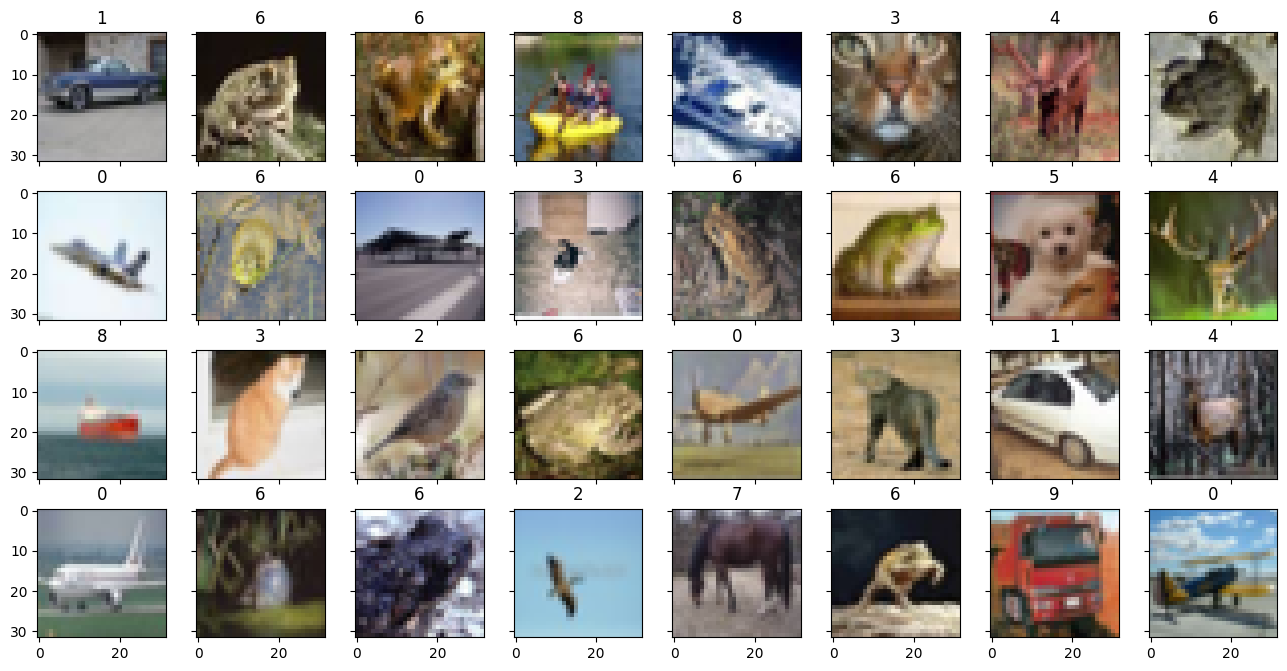

In [5]:
## Get first 32 images as samples
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
  ax.imshow(image)
  ax.set_title(label[0])

plt.show()

## Data Generator with Patch Augmentation

In [6]:
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(32, 32), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size
      self.X = X
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle

      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()

      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)

      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255

    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((32,32,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [7]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
valgen = createAugment(x_val, x_val)
testgen = createAugment(x_test, x_test, shuffle=False)

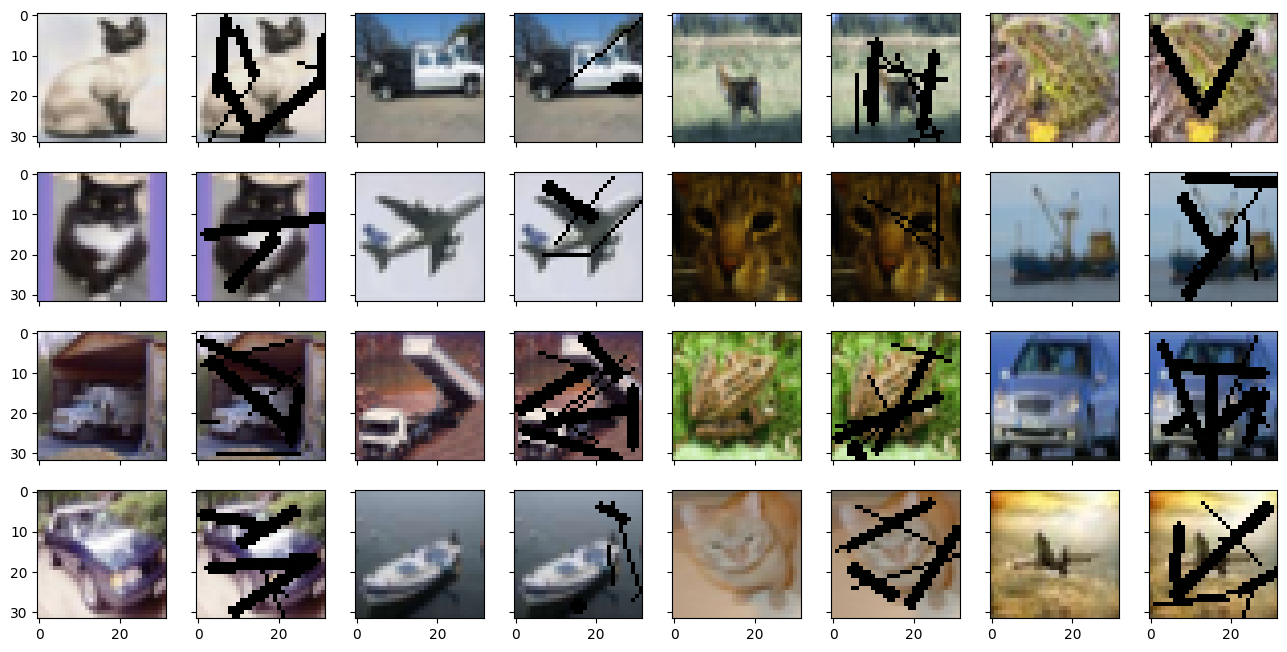

In [8]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

# Define Model (Autoencoder-Decoder Model)

In [9]:
## Metric
## Dice similarity coefficient (DSC) 
'''The Dice coefficient (Dice similarity coefficient or DSC) is a measure of overlap between two sets. It ranges from 0 to 1, where:
    - A Dice coefficient of 1 indicates perfect overlap between the two sets (i.e., the sets are identical).
    - A Dice coefficient of 0 indicates no overlap at all.'''
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def mse(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    return keras.backend.mean(keras.backend.square(y_true_f - y_pred_f))

In [10]:
class inpaintingModel:
  '''
  Build UNET like model for image inpaining
  '''
  def prepare_model(self, input_size=(32,32,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs)
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2)
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3)

    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

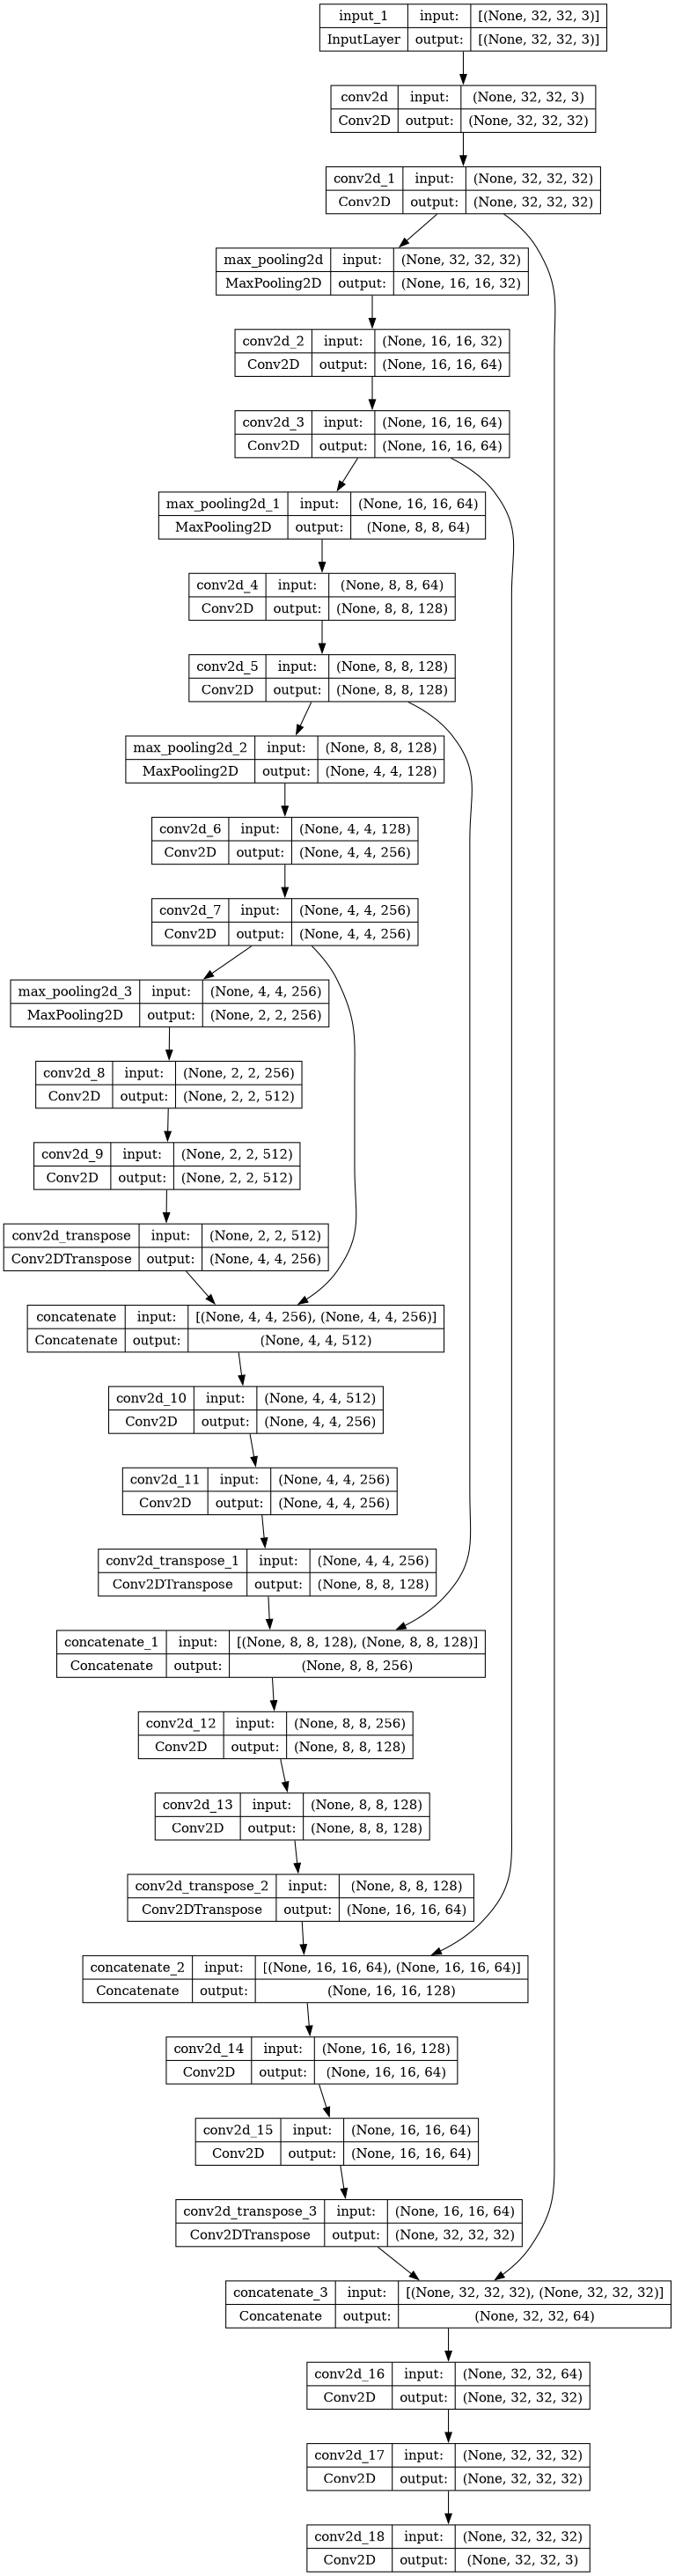

In [11]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef, mse])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')

# Train Model

In [12]:
csv_logger = CSVLogger('log_training.csv', append=True, separator=';')

In [13]:
# Record the start time
start_time = time.time()

history = model.fit(traingen,
              validation_data=valgen,
              epochs=20,
              steps_per_epoch=len(traingen),
              validation_steps=len(valgen),
              callbacks=csv_logger,
              use_multiprocessing=True,)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/20


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
I0000 00:00:1717787360.749820     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1245/1250 [============================>.] - ETA: 0s - loss: 0.0394 - dice_coef: 0.5956 - mse: 0.0044

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


1250/1250 [==============================] - 61s 38ms/step - loss: 0.0393 - dice_coef: 0.5956 - mse: 0.0044 - val_loss: 0.0252 - val_dice_coef: 0.5997 - val_mse: 0.0019
Epoch 2/20
1250/1250 [==============================] - 48s 38ms/step - loss: 0.0226 - dice_coef: 0.6017 - mse: 0.0017 - val_loss: 0.0181 - val_dice_coef: 0.6052 - val_mse: 0.0015
Epoch 3/20
1250/1250 [==============================] - 49s 39ms/step - loss: 0.0200 - dice_coef: 0.6023 - mse: 0.0015 - val_loss: 0.0203 - val_dice_coef: 0.6075 - val_mse: 0.0015
Epoch 4/20
1250/1250 [==============================] - 49s 39ms/step - loss: 0.0189 - dice_coef: 0.6026 - mse: 0.0014 - val_loss: 0.0248 - val_dice_coef: 0.6136 - val_mse: 0.0017
Epoch 5/20
1250/1250 [==============================] - 48s 38ms/step - loss: 0.0177 - dice_coef: 0.6028 - mse: 0.0014 - val_loss: 0.0164 - val_dice_coef: 0.6067 - val_mse: 0.0013
Epoch 6/20
1250/1250 [==============================] - 48s 38ms/step - loss: 0.0172 - dice_coef: 0.6030 - mse:

## Visualize Progress

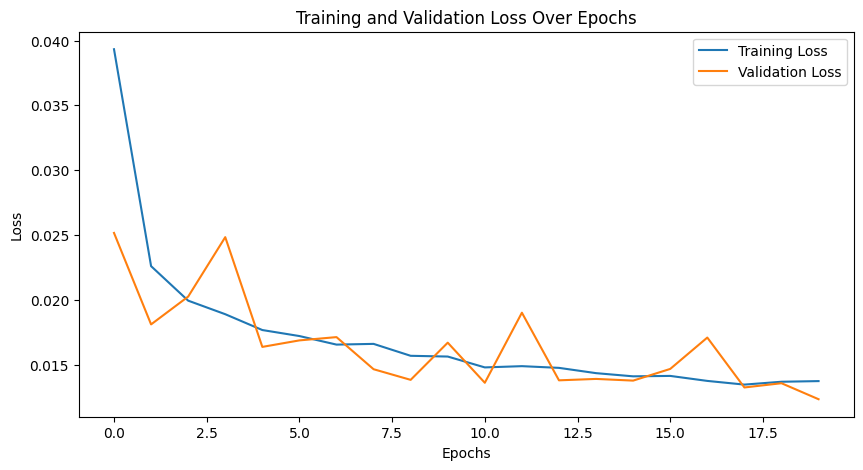

In [14]:
# Extract loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


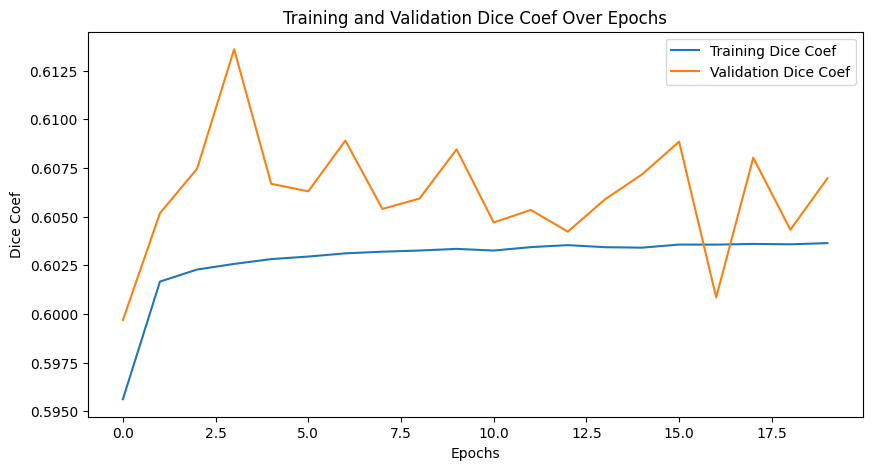

In [15]:
# Extract dice coef values from the history
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

# Plot the training and validation dice coef
plt.figure(figsize=(10, 5))
plt.plot(train_dice_coef, label='Training Dice Coef')
plt.plot(val_dice_coef, label='Validation Dice Coef')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.title('Training and Validation Dice Coef Over Epochs')
plt.legend()
plt.show()

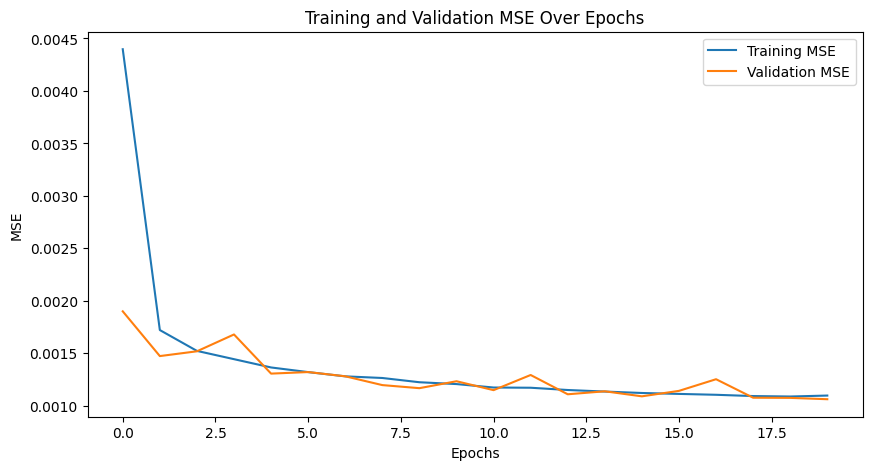

In [16]:
# Extract mse values from the history
train_mse = history.history['mse']
val_mse = history.history['val_mse']

# Plot the training and validation mse
plt.figure(figsize=(10, 5))
plt.plot(train_mse, label='Training MSE')
plt.plot(val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE Over Epochs')
plt.legend()
plt.show()

## Save Model

In [17]:
model.save('model_inpainting.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Evaluation

In [18]:
# Evaluate the model on the test data
test_loss, test_dice_coef, test_mse = model.evaluate(testgen, steps=len(testgen))
print(f'Test loss (MAE): {test_loss}')
print(f'Test dice coef: {test_dice_coef}')
print(f'Test MSE: {test_mse}')

312/312 [==============================] - 3s 10ms/step - loss: 0.0124 - dice_coef: 0.6070 - mse: 0.0011
Test loss (MAE): 0.012383288703858852
Test dice coef: 0.6070067286491394
Test MSE: 0.001062931027263403


## Visualize Some Predict

1/1 [==============================] - 0s 23ms/step


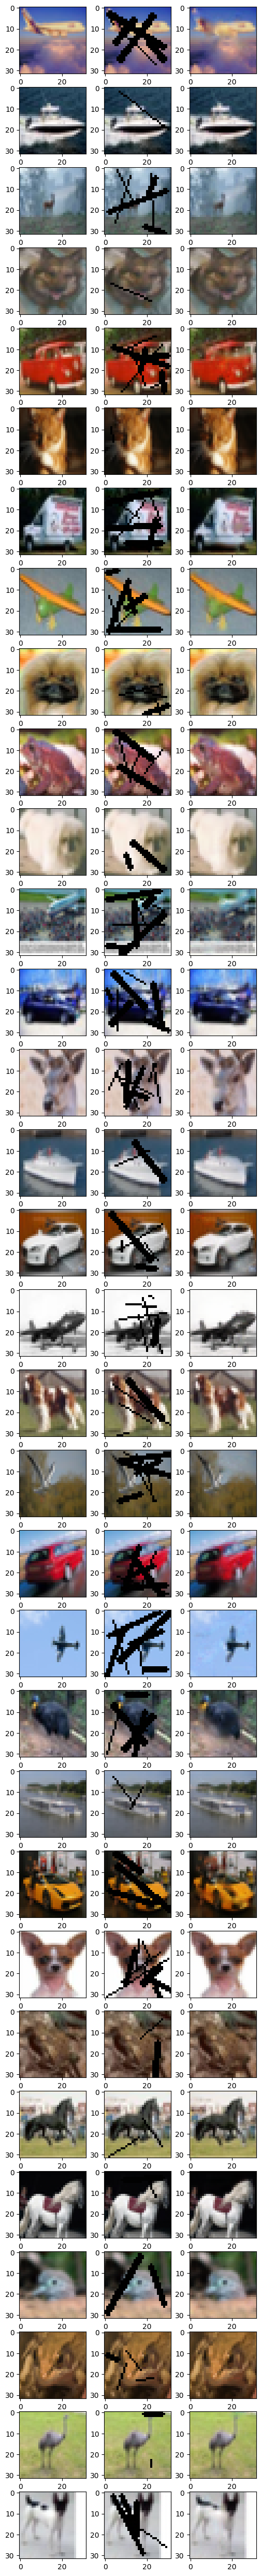

In [19]:
## Examples
rows = 32
sample_idx = 54
sample_images, sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()